In this notebook the code is used to validate the pretrained EHR-based model, CXR-based model fusion model in the Hoboken dataset.

## Llibraries

In [ ]:
import os, sys, math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

Tensorflow version 2.5.0


# CXR-based model

##Load model

In [ ]:
!wget 'https://storage.googleapis.com/new_cxr_30/models/cxr_models/k-foldall_augment_bboxB_dropout0.5_layers_not_trainable400_lr_init0.002_cxr_hidden_dims%5B128%2C%2064%5D_output_bias%5B-2.07156032%5D_pretrained_feature_layer-2_class_weight%7C0%7C%2010%2C%201%7C%2010%7C_loss_functionbinary_crossentropy.h5'

--2021-06-20 08:21:06--  https://storage.googleapis.com/new_cxr_30/models/cxr_models/k-foldall_augment_bboxB_dropout0.5_layers_not_trainable400_lr_init0.002_cxr_hidden_dims%5B128%2C%2064%5D_output_bias%5B-2.07156032%5D_pretrained_feature_layer-2_class_weight%7C0%7C%2010%2C%201%7C%2010%7C_loss_functionbinary_crossentropy.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35225912 (34M) [application/octet-stream]
Saving to: ‘k-foldall_augment_bboxB_dropout0.5_layers_not_trainable400_lr_init0.002_cxr_hidden_dims[128, 64]_output_bias[-2.07156032]_pretrained_feature_layer-2_class_weight|0| 10, 1| 10|_loss_functionbinary_crossentropy.h5’

k-foldall_augment_b 100%[===================>]  33.59M  57.4MB/s    in 0.6s    

2021-06-20 08:21:07 (57.4 MB/s) - ‘k-foldall_augment_bboxB_drop

In [ ]:
model = tf.keras.models.load_model('k-foldall_augment_bboxB_dropout0.5_layers_not_trainable400_lr_init0.002_cxr_hidden_dims[128, 64]_output_bias[-2.07156032]_pretrained_feature_layer-2_class_weight|0| 10, 1| 10|_loss_functionbinary_crossentropy.h5', compile=False)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Precision()]
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 326, 326, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 160, 160, 64) 3136        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# predictions = tf.keras.layers.Dense(1, activation='sigmoid', name="dense_a")(base_model.layers[-2].output)

# new_model = tf.keras.Model(inputs=model.layers[-1].input, outputs=model.layers[-1].output)

DL_input = tf.keras.Input(model.layers[-1].input_shape[1:])
new_model = DL_input
for layer in model.layers[-1:]:
    new_model = layer(new_model)
new_model = tf.keras.Model(inputs=DL_input, outputs=new_model)

new_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Precision()]
)

In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
pred_cxr (Dense)             (None, 1)                 65        
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


##Load image features

In [ ]:
import pandas as pd 

data = pd.read_csv("hoboken_image_feature_data_v2.csv") 

In [ ]:
#For hoboken features

toSwap = [[179,131],[225,230],[190,51],[166,201],[241,36],[63,24],[180,111],[162,164],[218,234],[38,221]]

for i in range(10):
  id1_data = data.iloc[data.index[data['PATIENT ID'] == toSwap[i][0]][0], range(47,111)].copy()
  id2_data = data.iloc[data.index[data['PATIENT ID'] == toSwap[i][1]][0], range(47,111)].copy()
  data.iloc[data.index[data['PATIENT ID'] == toSwap[i][0]][0], range(47,111)] = id2_data
  data.iloc[data.index[data['PATIENT ID'] == toSwap[i][1]][0], range(47,111)] = id1_data

fairness analysis

In [ ]:
# data = data[data['MALE'] == 0]   
# data = data[data['MALE'] == 1]

In [ ]:
feature = data.iloc[:, range(48,112)].to_numpy()

In [ ]:
feature

array([[-1.99756169,  0.5055955 ,  0.86572742, ...,  0.33615154,
        -3.78113866,  1.92153513],
       [-0.77084529, -0.44941413, -0.1921345 , ...,  0.46474391,
        -2.30063176,  1.04755533],
       [-0.27269161, -1.00909782, -1.04803062, ...,  0.55338317,
        -1.54380929,  0.97854131],
       ...,
       [ 0.87594366, -1.92245984, -2.04025745, ...,  0.34608716,
        -0.4931536 ,  0.20051339],
       [ 0.73627341, -1.84280801, -1.88716483, ...,  0.49756625,
        -0.31566304,  0.21030818],
       [-3.984972  ,  2.41867638,  2.16122103, ...,  0.02229096,
        -5.18635654,  2.80739045]])

In [ ]:
answer = data['expired_30_days'].to_numpy()

In [ ]:
feature.shape

(83, 64)

## Prediction

In [ ]:
out = new_model.predict(feature)

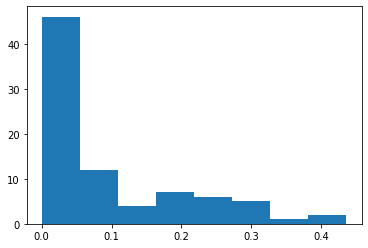

In [ ]:
_ = plt.hist(out, bins='auto')

In [ ]:
import sklearn.metrics
roc_auc = sklearn.metrics.roc_auc_score(answer, out)
# roc_auc = sklearn.metrics.roc_auc_score(label, out)

In [ ]:
print(roc_auc)

0.6558441558441559


## Reports and plots

In [ ]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(answer, out)
optimal_idx = np.argmin((1-tpr)**2+ (fpr)**2 )
optimal_threshold = thresholds[optimal_idx]

## use optimal cut-point 

a,b = np.where(out >= optimal_threshold)


predicted_class = np.zeros(len(out), dtype=int)
# predicted_class[np.where(out < optimal_threshold)] = 0
predicted_class[a] = 1

## use 0.5 as cut-point 
# predicted_class = np.zeros(len(out), dtype=int)
# predicted_class[out < 0.5] = 0
# predicted_class[out >= 0.5] = 1

# use softmax
# predicted_class = np.around(predictions).astype(int)
# predicted_class_name = np.array(CLASSES)[predicted_class].tolist()


tn, fp, fn, tp = sklearn.metrics.confusion_matrix(answer, predicted_class).ravel()
roc_auc = sklearn.metrics.roc_auc_score(answer, out)
sensitivity = tp / (tp + fn) # recall
specificity = tn / (tn + fp)
PPV = tp / (tp + fp) #precision
NPV = tn / (tn + fn) #NPV
f1 = 2 * ((tp / (tp + fp)) * (tp / (tp + fn)) )/ ((tp / (tp + fp)) + (tp / (tp + fn)))
acc = (tp + tn) / (tn + fp + fn + tp)

print(f'AUROC: {roc_auc:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'PPV: {PPV:.2f}')
print(f'NPV: {NPV:.2f}')    
print(f'F1-score: {f1:.2f}')
print(f'Accuracy: {acc:.2f}')
print(f'tn, fp, fn, tp: {tn, fp, fn, tp}')

AUROC: 0.66
Sensitivity: 0.61
Specificity: 0.62
PPV: 0.45
NPV: 0.76
F1-score: 0.52
Accuracy: 0.61
tn, fp, fn, tp: (34, 21, 11, 17)


In [ ]:
import statistics

n_bootstraps = 1000
rng_seed = 47  # control reproducibility
bootstrapped_auc = []
bootstrapped_specificity = []
bootstrapped_sensitivity = []
bootstrapped_PPV = []
bootstrapped_NPV = []
bootstrapped_f1 = []
bootstrapped_acc = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(out), len(out))
    while len(np.unique(answer[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        indices = rng.randint(0, len(out), len(out))


    fpr, tpr, thresholds = sklearn.metrics.roc_curve(answer[indices], out[indices])
    optimal_idx = np.argmin((1-tpr)**2+ (fpr)**2 )
    optimal_threshold = thresholds[optimal_idx]

    a,b = np.where(out >= optimal_threshold)
    predicted_class = np.zeros(len(out), dtype=int)
    predicted_class[a] = 1

    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(answer[indices], predicted_class[indices]).ravel()

    auc = sklearn.metrics.roc_auc_score(answer[indices], out[indices])
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn) # recall
    PPV = tp / (tp + fp) #precision
    NPV = tn / (tn + fn) #NPV
    # f1 = 2 * ((tp / (tp + fp)) * (tp / (tp + fn)) )/ ((tp / (tp + fp)) + (tp / (tp + fn)))
    f1 = sklearn.metrics.f1_score(answer[indices], predicted_class[indices])
    acc = (tp + tn) / (tn + fp + fn + tp)

    bootstrapped_auc.append(auc)
    bootstrapped_specificity.append(specificity)
    bootstrapped_sensitivity.append(sensitivity)
    bootstrapped_PPV.append(PPV)
    bootstrapped_NPV.append(NPV)
    bootstrapped_f1.append(f1)
    bootstrapped_acc.append(acc)

print("AUROC: {:0.4f} +- {:0.4f}".format(statistics.mean(bootstrapped_auc), statistics.stdev(bootstrapped_auc)))      
print("Sensitivity(%): {:0.2f} +- {:0.2f}".format(statistics.mean(bootstrapped_sensitivity)*100, statistics.stdev(bootstrapped_sensitivity)*100))
print("Specificity(%): {:0.2f} +- {:0.2f}".format(statistics.mean(bootstrapped_specificity)*100, statistics.stdev(bootstrapped_specificity)*100)) 
print("PPV(%): {:0.2f} +- {:0.2f}".format(statistics.mean(bootstrapped_PPV)*100, statistics.stdev(bootstrapped_PPV)*100))
print("NPV(%): {:0.2f} +- {:0.2f}".format(statistics.mean(bootstrapped_NPV)*100, statistics.stdev(bootstrapped_NPV)*100))
print("f1-score: {:0.4f} +- {:0.4f}".format(statistics.mean(bootstrapped_f1), statistics.stdev(bootstrapped_f1)))
print("Accuracy(%): {:0.2f} +- {:0.2f}".format(statistics.mean(bootstrapped_acc)*100, statistics.stdev(bootstrapped_acc)*100))


sorted_auc = np.array(bootstrapped_auc)
sorted_auc.sort()
confidence_lower_auc = sorted_auc[int(0.05 * len(sorted_auc))]
confidence_upper_auc = sorted_auc[int(0.95 * len(sorted_auc))]

sorted_sen = np.array(bootstrapped_sensitivity)
sorted_sen.sort()
confidence_lower_sen = sorted_sen[int(0.05 * len(sorted_sen))]
confidence_upper_sen = sorted_sen[int(0.95 * len(sorted_sen))]

sorted_spe = np.array(bootstrapped_specificity)
sorted_spe.sort()
confidence_lower_spe = sorted_spe[int(0.05 * len(sorted_spe))]
confidence_upper_spe = sorted_spe[int(0.95 * len(sorted_spe))]

sorted_ppv = np.array(bootstrapped_PPV)
sorted_ppv.sort()
confidence_lower_ppv = sorted_ppv[int(0.05 * len(sorted_ppv))]
confidence_upper_ppv = sorted_ppv[int(0.95 * len(sorted_ppv))]

sorted_npv = np.array(bootstrapped_NPV)
sorted_npv.sort()
confidence_lower_npv = sorted_npv[int(0.05 * len(sorted_npv))]
confidence_upper_npv = sorted_npv[int(0.95 * len(sorted_npv))]

sorted_f1 = np.array(bootstrapped_f1)
sorted_f1.sort()
confidence_lower_f1 = sorted_f1[int(0.05 * len(sorted_f1))]
confidence_upper_f1 = sorted_f1[int(0.95 * len(sorted_f1))]

sorted_acc = np.array(bootstrapped_acc)
sorted_acc.sort()
confidence_lower_acc = sorted_acc[int(0.05 * len(sorted_acc))]
confidence_upper_acc = sorted_acc[int(0.95 * len(sorted_acc))]


print("Confidence interval for the auc: [{:0.2f}-{:0.2}]".format(confidence_lower_auc, confidence_upper_auc))     
print("Confidence interval for the sen: [{:0.2f}-{:0.2}]".format(confidence_lower_sen, confidence_upper_sen))
print("Confidence interval for the spe: [{:0.2f}-{:0.2}]".format(confidence_lower_spe, confidence_upper_spe))
print("Confidence interval for the ppv: [{:0.2f}-{:0.2}]".format(confidence_lower_ppv, confidence_upper_ppv))
print("Confidence interval for the npv: [{:0.2f}-{:0.2}]".format(confidence_lower_npv, confidence_upper_npv))
print("Confidence interval for the f1: [{:0.2f}-{:0.2}]".format(confidence_lower_f1, confidence_upper_f1))
print("Confidence interval for the acc: [{:0.2f}-{:0.2}]".format(confidence_lower_acc, confidence_upper_acc))

AUROC: 0.6572 +- 0.0613
Sensitivity(%): 64.97 +- 11.25
Specificity(%): 63.67 +- 11.42
PPV(%): 48.63 +- 8.85
NPV(%): 78.23 +- 6.26
f1-score: 0.5471 +- 0.0680
Accuracy(%): 64.16 +- 6.08
Confidence interval for the auc: [0.55-0.76]
Confidence interval for the sen: [0.48-0.85]
Confidence interval for the spe: [0.44-0.82]
Confidence interval for the ppv: [0.35-0.65]
Confidence interval for the npv: [0.67-0.88]
Confidence interval for the f1: [0.44-0.66]
Confidence interval for the acc: [0.54-0.75]


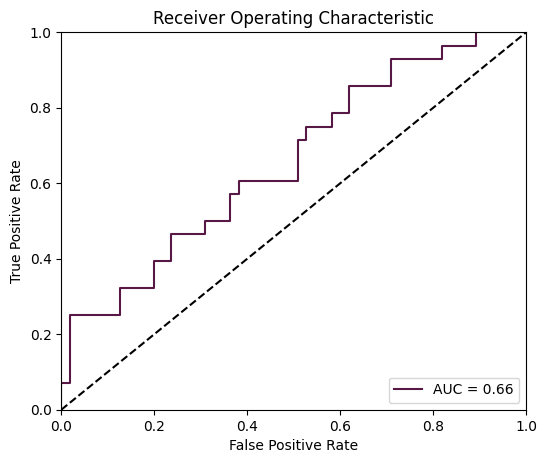

In [ ]:

plt.figure(figsize=(6,5),dpi=100)
plt.title('Receiver Operating Characteristic')

color_list = ['#581845','#900C3F','#C70039','#FF5733']
col = 0

from sklearn import metrics

# for clf_name,clf in clf_list:
#     clf = clf.best_estimator_
    # y_prob = clf.predict_proba(x_test)
# prob = y_prob[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(answer, out)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color_list[col], label = f'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
col += 1
plt.savefig("HOBOKEN_CXR.svg")

plt.show();

In [ ]:
# np.savetxt("hoboken_prediction_prob.csv", out, delimiter=",")
np.savetxt("snuh_prediction_prob.csv", out, delimiter=",")

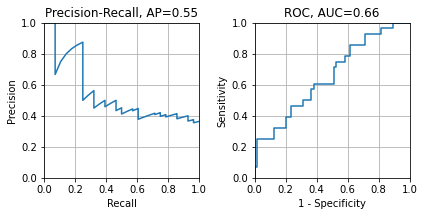

In [ ]:
fig, axes = plt.subplots(1, 2)

# Plot the precision-recall curve
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(answer, out)
average_precision = sklearn.metrics.average_precision_score(answer, out)

pr_axis = axes[0]
pr_axis.plot(recall, precision)
pr_axis.set_aspect('equal')
pr_axis.set_xlim(0, 1)
pr_axis.set_ylim(0, 1)
pr_axis.set_xlabel('Recall')
pr_axis.set_ylabel('Precision')
pr_axis.set_title('Precision-Recall, AP={:.2f}'.format(average_precision))
pr_axis.grid(True)

# Plot the ROC curve
fpr, tpr, thresholds = sklearn.metrics.roc_curve(answer, out)
roc_auc = sklearn.metrics.roc_auc_score(answer, out)

roc_axis = axes[1]
roc_axis.plot(fpr, tpr)
roc_axis.set_aspect('equal')
roc_axis.set_xlim(0, 1)
roc_axis.set_ylim(0, 1)
roc_axis.set_xlabel('1 - Specificity')
roc_axis.set_ylabel('Sensitivity')
roc_axis.set_title('ROC, AUC={:.2f}'.format(roc_auc))
roc_axis.grid(True)

plt.tight_layout()

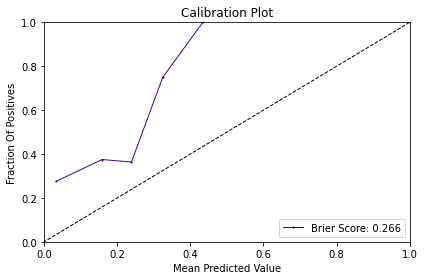

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

title_calibration='Calibration Plot'
plt.title(title_calibration)
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.ylabel("Fraction Of Positives")
plt.xlabel("Mean Predicted Value")
plt.plot([1, 0], [1, 0],"k--",linewidth=1)

fraction_of_positives, mean_predicted_value = calibration_curve(answer, out,n_bins=10)
brier_score = brier_score_loss(answer, out)
plt.plot(mean_predicted_value, fraction_of_positives, "rs-",markersize=1,label=f'Brier Score: {np.round(brier_score,3)}',color='indigo',linewidth=1)
plt.legend(loc="lower right")
plt.tight_layout()

# EHR-based and EHR-CXR fusion models

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load and check the variables 

In [ ]:
df_hm = pd.read_csv('/content/gdrive/MyDrive/covid19/predictions_cxr_model_4fold_models_predictions_v2.csv')

In [ ]:
df_hm = df_hm.drop(columns=['Unnamed: 0', 'SOPInstanceUID','path','APview','bbox_coordinates','expired_30_days', 'fold'])
df_hm = df_hm.set_index('patient_id')
df_hm = df_hm.sort_index()


In [ ]:
a = list(df_hm.columns)

Fairness analysis

In [ ]:
# EHR_data = data[data['MALE'] == 0]   
# EHR_data = data[data['MALE'] == 1]

In [ ]:
y_test = EHR_data['expired_30_days'].to_numpy()
EHR_data = EHR_data.drop(columns='expired_30_days')

In [ ]:
EHR_data = EHR_data.iloc[:, range(1,48)]

In [ ]:
b = list(EHR_data.columns)

In [ ]:
list(set(a) - set(b))

[]

In [ ]:
EHR_data = EHR_data[a]

Drop CXR-model result for EHR-based model

In [ ]:
# EHR_data = EHR_data.drop(columns='predicted_probability')

## Load model

In [ ]:
from sklearn.externals import joblib
from sklearn.metrics import classification_report, precision_recall_curve, plot_precision_recall_curve, average_precision_score, brier_score_loss, roc_curve
import glob

model_path = './gdrive/My Drive/covid19/models/'

fpath = glob.glob(model_path+'*_str_only_bestf11.pkl') 
# fpath = glob.glob(model_path+'*_bestf11.pkl') 

# fpath = glob.glob(model_path+'*_fusion_model_bestf11.pkl') 
# fpath = glob.glob(model_path+'*_EHR_model_bestf11.pkl') 

clf = joblib.load(os.path.join(fpath[0])) 

## Prediction

In [ ]:
ypred = clf.predict(EHR_data)
y_prob = clf.predict_proba(EHR_data)
print(classification_report(y_true=y_test,y_pred=ypred))
print(clf.score)

              precision    recall  f1-score   support

           0       0.55      0.95      0.70        59
           1       0.82      0.24      0.37        59

    accuracy                           0.59       118
   macro avg       0.69      0.59      0.53       118
weighted avg       0.69      0.59      0.53       118

<bound method ClassifierMixin.score of SGDClassifier(alpha=5.2985619275654474e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.25549353080104803, learning_rate='optimal', loss='log',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=2020, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)>


## Reports and plots

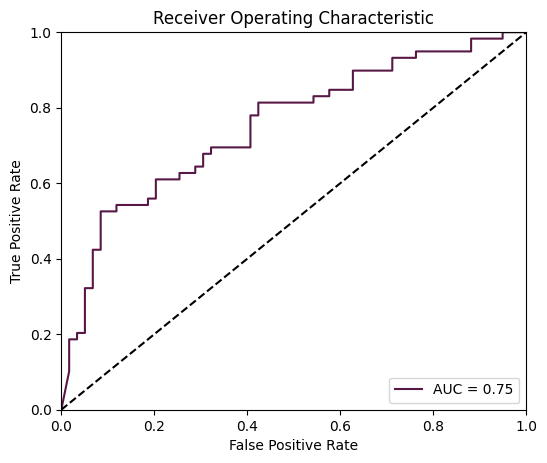

In [ ]:
plt.figure(figsize=(6,5),dpi=100)
plt.title('Receiver Operating Characteristic')

color_list = ['#581845','#900C3F','#C70039','#FF5733']
col = 0

from sklearn import metrics

# for clf_name,clf in clf_list:
#     clf = clf.best_estimator_
    # y_prob = clf.predict_proba(x_test)
prob = y_prob[:,1]
fpr, tpr, threshold = roc_curve(y_test, prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color_list[col], label = f'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
col += 1
plt.savefig("output.svg")

plt.show();

In [ ]:
import sklearn.metrics
from sklearn.metrics import roc_auc_score, recall_score, make_scorer


fpr, tpr, thresholds = roc_curve(y_test, prob)
optimal_idx = np.argmin((1-tpr)**2+ (fpr)**2 )
optimal_threshold = thresholds[optimal_idx]

## use optimal cut-point 
predicted_class = np.zeros(len(prob), dtype=int)
predicted_class[prob < optimal_threshold] = 0
predicted_class[prob >= optimal_threshold] = 1

## use 0.5 as cut-point 
# predicted_class[predictions < 0.5] = 0
# predicted_class[predictions >= 0.5] = 1
# predicted_class_name = np.array(CLASSES)[predicted_class].tolist()

# use softmax
# predicted_class = np.around(predictions).astype(int)
# predicted_class_name = np.array(CLASSES)[predicted_class].tolist()


tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, predicted_class).ravel()
roc_auc = roc_auc_score(y_test, prob)
sensitivity = tp / (tp + fn) # recall
specificity = tn / (tn + fp)
PPV = tp / (tp + fp) #precision
NPV = tn / (tn + fn) #NPV
f1 = 2 * ((tp / (tp + fp)) * (tp / (tp + fn)) )/ ((tp / (tp + fp)) + (tp / (tp + fn)))
acc = (tp + tn) / (tn + fp + fn + tp)

print(f'AUROC: {roc_auc:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'PPV: {PPV:.2f}')
print(f'NPV: {NPV:.2f}')    
print(f'F1-score: {f1:.2f}')
print(f'Accuracy: {acc:.2f}')
print(f'tn, fp, fn, tp: {tn, fp, fn, tp}')

AUROC: 0.75
Sensitivity: 0.61
Specificity: 0.80
PPV: 0.75
NPV: 0.67
F1-score: 0.67
Accuracy: 0.70
tn, fp, fn, tp: (47, 12, 23, 36)


In [ ]:
import statistics

n_bootstraps = 1000
rng_seed = 47  # control reproducibility
bootstrapped_auc = []
bootstrapped_specificity = []
bootstrapped_sensitivity = []
bootstrapped_PPV = []
bootstrapped_NPV = []
bootstrapped_f1 = []
bootstrapped_acc = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(prob), len(prob))
    while len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        indices = rng.randint(0, len(prob), len(prob))


    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test[indices], prob[indices])
    optimal_idx = np.argmin((1-tpr)**2+ (fpr)**2 )
    optimal_threshold = thresholds[optimal_idx]
    predicted_class = np.zeros(len(prob))
    predicted_class[prob > optimal_threshold] = 1
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test[indices], predicted_class[indices]).ravel()

    auc = sklearn.metrics.roc_auc_score(y_test[indices], prob[indices])
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn) # recall
    PPV = tp / (tp + fp) #precision
    NPV = tn / (tn + fn) #NPV
    # f1 = 2 * ((tp / (tp + fp)) * (tp / (tp + fn)) )/ ((tp / (tp + fp)) + (tp / (tp + fn)))
    f1 = sklearn.metrics.f1_score(y_test[indices], predicted_class[indices])
    acc = (tp + tn) / (tn + fp + fn + tp)

    bootstrapped_auc.append(auc)
    bootstrapped_specificity.append(specificity)
    bootstrapped_sensitivity.append(sensitivity)
    bootstrapped_PPV.append(PPV)
    bootstrapped_NPV.append(NPV)
    bootstrapped_f1.append(f1)
    bootstrapped_acc.append(acc)

print("AUROC: {:0.4f} +- {:0.4f}".format(statistics.mean(bootstrapped_auc), statistics.stdev(bootstrapped_auc)))      
print("Sensitivity(%): {:0.2f} +- {:0.2f}".format(statistics.mean(bootstrapped_sensitivity)*100, statistics.stdev(bootstrapped_sensitivity)*100))
print("Specificity(%): {:0.2f} +- {:0.2f}".format(statistics.mean(bootstrapped_specificity)*100, statistics.stdev(bootstrapped_specificity)*100)) 
print("PPV(%): {:0.2f} +- {:0.2f}".format(statistics.mean(bootstrapped_PPV)*100, statistics.stdev(bootstrapped_PPV)*100))
print("NPV(%): {:0.2f} +- {:0.2f}".format(statistics.mean(bootstrapped_NPV)*100, statistics.stdev(bootstrapped_NPV)*100))
print("f1-score: {:0.4f} +- {:0.4f}".format(statistics.mean(bootstrapped_f1), statistics.stdev(bootstrapped_f1)))
print("Accuracy(%): {:0.2f} +- {:0.2f}".format(statistics.mean(bootstrapped_acc)*100, statistics.stdev(bootstrapped_acc)*100))


sorted_auc = np.array(bootstrapped_auc)
sorted_auc.sort()
confidence_lower_auc = sorted_auc[int(0.05 * len(sorted_auc))]
confidence_upper_auc = sorted_auc[int(0.95 * len(sorted_auc))]

sorted_sen = np.array(bootstrapped_sensitivity)
sorted_sen.sort()
confidence_lower_sen = sorted_sen[int(0.05 * len(sorted_sen))]
confidence_upper_sen = sorted_sen[int(0.95 * len(sorted_sen))]

sorted_spe = np.array(bootstrapped_specificity)
sorted_spe.sort()
confidence_lower_spe = sorted_spe[int(0.05 * len(sorted_spe))]
confidence_upper_spe = sorted_spe[int(0.95 * len(sorted_spe))]

sorted_ppv = np.array(bootstrapped_PPV)
sorted_ppv.sort()
confidence_lower_ppv = sorted_ppv[int(0.05 * len(sorted_ppv))]
confidence_upper_ppv = sorted_ppv[int(0.95 * len(sorted_ppv))]

sorted_npv = np.array(bootstrapped_NPV)
sorted_npv.sort()
confidence_lower_npv = sorted_npv[int(0.05 * len(sorted_npv))]
confidence_upper_npv = sorted_npv[int(0.95 * len(sorted_npv))]

sorted_f1 = np.array(bootstrapped_f1)
sorted_f1.sort()
confidence_lower_f1 = sorted_f1[int(0.05 * len(sorted_f1))]
confidence_upper_f1 = sorted_f1[int(0.95 * len(sorted_f1))]

sorted_acc = np.array(bootstrapped_acc)
sorted_acc.sort()
confidence_lower_acc = sorted_acc[int(0.05 * len(sorted_acc))]
confidence_upper_acc = sorted_acc[int(0.95 * len(sorted_acc))]


print("Confidence interval for the auc: [{:0.2f}-{:0.2}]".format(confidence_lower_auc, confidence_upper_auc))     
print("Confidence interval for the sen: [{:0.2f}-{:0.2}]".format(confidence_lower_sen, confidence_upper_sen))
print("Confidence interval for the spe: [{:0.2f}-{:0.2}]".format(confidence_lower_spe, confidence_upper_spe))
print("Confidence interval for the ppv: [{:0.2f}-{:0.2}]".format(confidence_lower_ppv, confidence_upper_ppv))
print("Confidence interval for the npv: [{:0.2f}-{:0.2}]".format(confidence_lower_npv, confidence_upper_npv))
print("Confidence interval for the f1: [{:0.2f}-{:0.2}]".format(confidence_lower_f1, confidence_upper_f1))
print("Confidence interval for the acc: [{:0.2f}-{:0.2}]".format(confidence_lower_acc, confidence_upper_acc))

AUROC: 0.7508 +- 0.0451
Sensitivity(%): 66.16 +- 8.57
Specificity(%): 74.54 +- 9.48
PPV(%): 73.05 +- 7.58
NPV(%): 68.88 +- 5.74
f1-score: 0.6885 +- 0.0515
Accuracy(%): 70.37 +- 4.11
Confidence interval for the auc: [0.67-0.82]
Confidence interval for the sen: [0.53-0.8]
Confidence interval for the spe: [0.58-0.9]
Confidence interval for the ppv: [0.61-0.87]
Confidence interval for the npv: [0.59-0.78]
Confidence interval for the f1: [0.60-0.77]
Confidence interval for the acc: [0.64-0.77]
